In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

from flygym import SingleFlySimulation
from flygym.arena.tethered import Tethered
from nmf_grooming import all_groom_dofs, GroomingCamera, GroomingFly


In [3]:
timestep = 1e-4

In [4]:
xml_variant = "deepfly3d_original"

data_path = Path(f"/Users/stimpfli/Desktop/nmf2-paper/grooming/data/220807_aJO-Gal4xUAS-CsChr_fly002_beh002/pose-3d/{xml_variant}")
with open(data_path / "leg_joint_angles.pkl", "rb") as f:
    leg_data = pickle.load(f)

with open(data_path / "head_joint_angles.pkl", "rb") as f:
    head_data = pickle.load(f)

# merge the dict (have different keys)
data_raw = {**leg_data, **head_data}
print(data_raw.keys())

data_raw["meta"] = {"timestep":1e-2}

dict_keys(['Angle_RF_ThC_yaw', 'Angle_RF_ThC_pitch', 'Angle_RF_ThC_roll', 'Angle_RF_CTr_pitch', 'Angle_RF_CTr_roll', 'Angle_RF_FTi_pitch', 'Angle_RF_TiTa_pitch', 'Angle_LF_ThC_yaw', 'Angle_LF_ThC_pitch', 'Angle_LF_ThC_roll', 'Angle_LF_CTr_pitch', 'Angle_LF_CTr_roll', 'Angle_LF_FTi_pitch', 'Angle_LF_TiTa_pitch', 'Angle_head_roll', 'Angle_head_pitch', 'Angle_head_yaw', 'Angle_antenna_yaw_L', 'Angle_antenna_pitch_L', 'Angle_antenna_yaw_R', 'Angle_antenna_pitch_R'])


In [5]:
# reformat the data
joint_corresp = {"ThC":"Coxa", "CTr":"Femur", "FTi":"Tibia", "TiTa":"Tarsus1"}

data = {}
for key, value in data_raw.items():
    if key == "meta":
        data[key] = value
        continue
    elif "head" in key:
        _, joint, dof = key.split("_")
        side = ""
        joint = "Head"
    elif "antenna" in key:
        _, joint, dof, side = key.split("_")
        joint = "Pedicel"
    else:
        _, side, joint, dof = key.split("_")
        joint = joint_corresp[joint]
    new_key = f"joint_{side}{joint}"
    if not dof == "pitch":
        new_key += f"_{dof}"
    
    data[new_key] = value

print(data.keys())

dict_keys(['joint_RFCoxa_yaw', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_LFCoxa_yaw', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_Head_roll', 'joint_Head', 'joint_Head_yaw', 'joint_LPedicel_yaw', 'joint_LPedicel', 'joint_RPedicel_yaw', 'joint_RPedicel', 'meta'])


In [6]:
target_num_steps = int(len(data["joint_LFCoxa"])/timestep*data["meta"]["timestep"])
data_block = np.zeros((len(all_groom_dofs), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * timestep
for i, joint in enumerate(all_groom_dofs):
    if "RPedicel_yaw" in joint:
            # data[joint] = np.ones_like(data[joint])*np.mean(data[joint])*-1
            data[joint] *= -1
    data_block[i, :] = np.unwrap(np.interp(output_t, input_t, data[joint]))

# swap head roll and head yaw
hroll_id = all_groom_dofs.index("joint_Head_roll")
hyaw_id = all_groom_dofs.index("joint_Head_yaw")
hroll = data_block[hroll_id, :].copy()
data_block[hroll_id, :] = data_block[hyaw_id, :] 

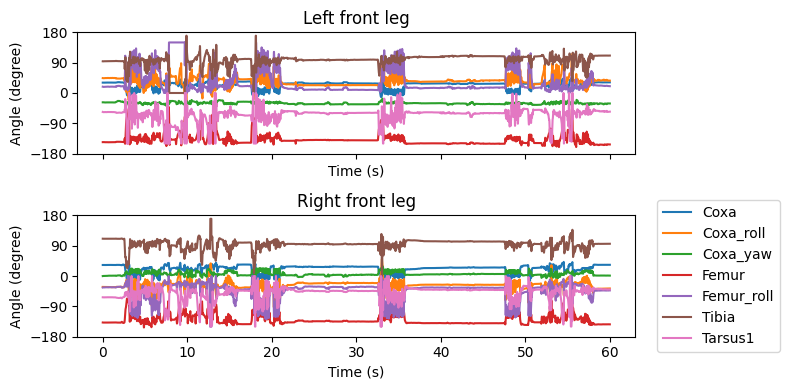

In [7]:
fig, axs = plt.subplots(
    2, 1, figsize=(8, 4), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.ravel()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(all_groom_dofs):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(output_t, np.rad2deg(data_block[j, :]), label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

Path("outputs/").mkdir(exist_ok=True)
fig.savefig("outputs/kin_replay_joint_dof_time_series.png")

In [8]:
video_fps = 100

start_t = 3.5
end_t = 6
focus_t = np.arange(start_t, end_t, timestep)
start_step = int(start_t / timestep)
end_step = int(end_t / timestep)
target_num_steps = end_step - start_step

data_block_focus = data_block[:, start_step:end_step]

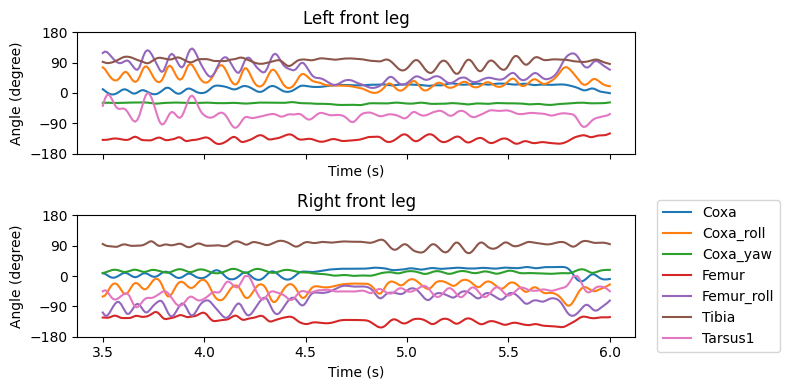

In [9]:
fig, axs = plt.subplots(
    2, 1, figsize=(8, 4), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.ravel()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(all_groom_dofs):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(focus_t, np.rad2deg(data_block_focus[j, :]), label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

Path("outputs/").mkdir(exist_ok=True)
fig.savefig("outputs/kin_replay_joint_dof_time_series.png")

In [12]:
fly = GroomingFly(xml_variant=xml_variant)
cam = GroomingCamera(fly, camera_id="Animat/camera_front")
cam._eff_render_interval = 1 / video_fps
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    arena=Tethered(),
)

timestamps = []


obs, info = sim.reset()

for i in range(50):
    sim.step({"joints": data_block_focus[:, 0]})

sim.curr_time = 0.0

for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block_focus[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = sim.step(action)
    frame = sim.render()
    if frame:
        timestamps.append(sim.curr_time)

cam.save_video(f"outputs/kin_replay_tcrop_{xml_variant}.mp4", 0)

ValueError: Camera 1/camera_front not recognized

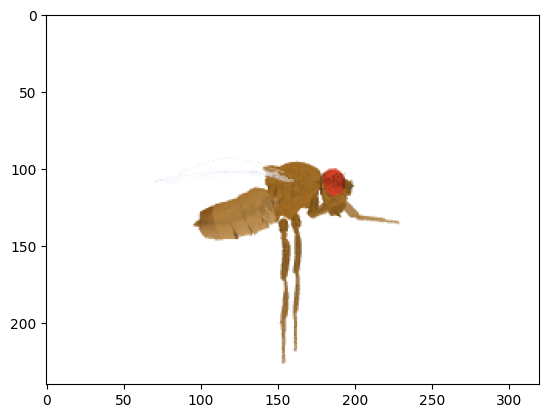

In [ ]:
sim.reset()
plt.imshow(sim.physics.render(camera_id="0/camera_right"))

# extract frames from video

In [ ]:
import os
import cv2 
video = Path("/Users/stimpfli/Desktop/nmf2-paper/grooming/data/220807_aJO-Gal4xUAS-CsChr_fly002_beh002/videos/camera_3.mp4")
# Extract frames between start and end time

cap = cv2.VideoCapture(str(video))
cap.set(cv2.CAP_PROP_POS_MSEC, start_t * 1000)
num_frames = int((end_t - start_t) * video_fps)

base_video_frames = []

for i in range(num_frames):
    ret, frame = cap.read()
    if not ret:
        break
    base_video_frames.append(frame)

cap.release()

In [ ]:
len(base_video_frames), len(cam._frames)

(250, 0)

In [ ]:
# generate side by side video

assert len(base_video_frames) == len(cam._frames)

out = cv2.VideoWriter(
    f"outputs/kin_replay_tcrop_{xml_variant}_side_by_side.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    video_fps,
    (base_video_frames[0].shape[1] + cam._frames[0].shape[1], base_video_frames[0].shape[0]),
)

for i in range(num_frames):
    frame = cv2.hconcat([base_video_frames[i], cam._frames[i][:, :, [2, 1, 0]]])
    out.write(frame)

out.release()

AssertionError: 